This experiment shows the arrucary of data recorded on the physical car (by analysing a rosbag)
It should help to fill the sim to real gap

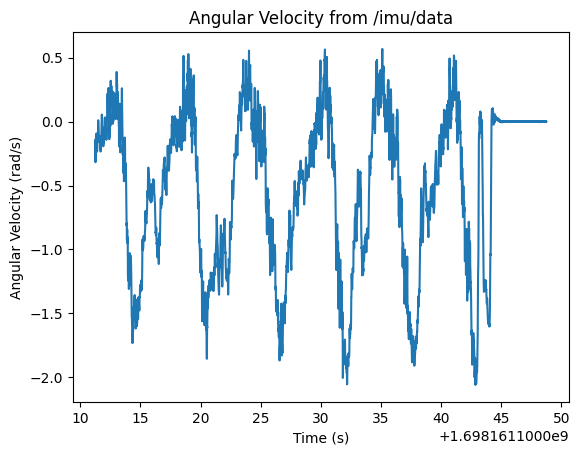

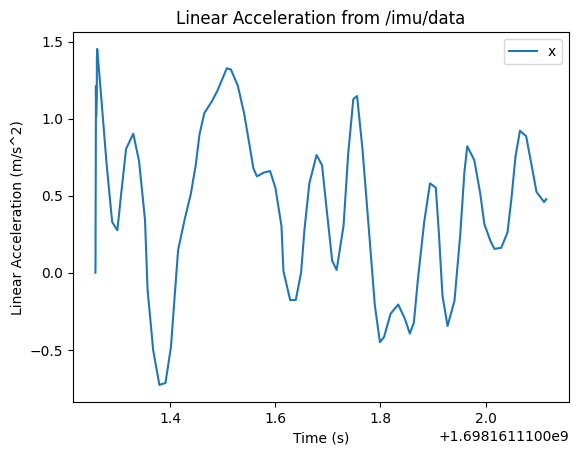

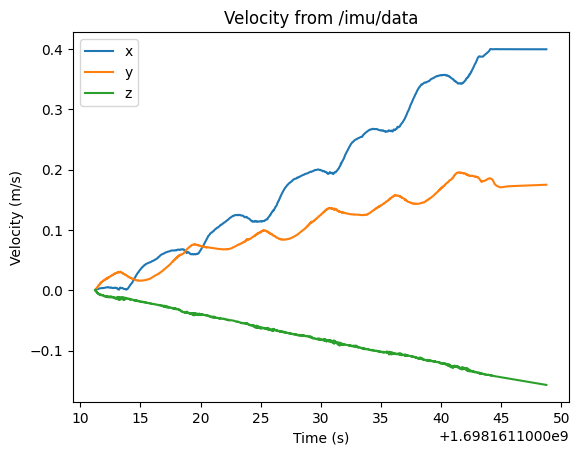

In [4]:

# Read the IMU data

import rosbag
import matplotlib.pyplot as plt
import numpy as np

# Open the rosbag file
bag = rosbag.Bag('rosbags/pp_ETF1_2023-10-24-17-25-09.bag')

time = []
angular_velocity = []
linear_acceleration_x = []
linear_acceleration_y = []
linear_acceleration_z = []

# Iterate over the bag
for topic, msg, t in bag.read_messages(topics=['/imu/data']):
    
    time.append(t.to_sec())
    angular_velocity.append(msg.angular_velocity.z)
    linear_acceleration_x.append(msg.linear_acceleration.x)
    linear_acceleration_y.append(msg.linear_acceleration.y)
    linear_acceleration_z.append(msg.linear_acceleration.z)

# Convert to numpy arrays
time = np.array(time)
angular_velocity = np.array(angular_velocity)
linear_acceleration_x = np.array(linear_acceleration_x)
linear_acceleration_y = np.array(linear_acceleration_y)
linear_acceleration_z = np.array(linear_acceleration_z)



# Plot angular velocity
plt.figure()
plt.plot(time, angular_velocity)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity from /imu/data')
plt.show()

# Plot linear acceleration
plt.figure()
plt.plot(time, linear_acceleration_x, label='x')
plt.plot(time, linear_acceleration_y, label='y')
plt.plot(time, linear_acceleration_z, label='z')
plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration (m/s^2)')
plt.title('Linear Acceleration from /imu/data')
plt.legend()
plt.show()


# Calculate velocity by integrating acceleration
velocity_x = np.cumsum(linear_acceleration_x) * (time[1] - time[0]) # assuming uniform time steps
velocity_y = np.cumsum(linear_acceleration_y) * (time[1] - time[0])
velocity_z = np.cumsum(linear_acceleration_z) * (time[1] - time[0])


# Plot velocity
plt.figure()
plt.plot(time, velocity_x, label='x')
plt.plot(time, velocity_y, label='y')
plt.plot(time, velocity_z, label='z')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity from /imu/data')
plt.legend()
plt.show()


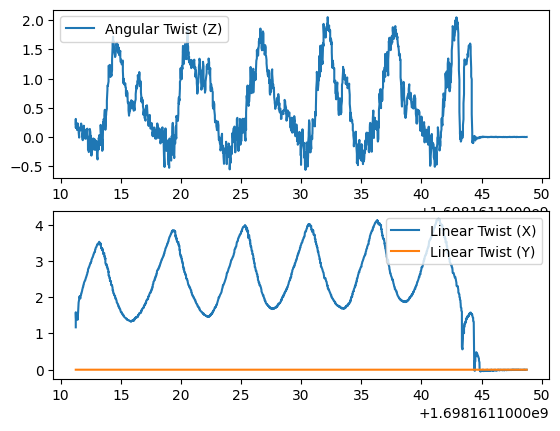

In [ ]:
# Read the odometry data (EKF)

import rosbag
import matplotlib.pyplot as plt
import numpy as np

bag = rosbag.Bag('rosbags/pp_ETF1_2023-10-24-17-25-09.bag')

time = []
angular_z = []
linear_x = []
linear_y = []

for topic, msg, t in bag.read_messages(topics=['/ekf/odometry/filtered']):
    # if isinstance(msg, Odometry):
    time.append(t.to_sec())
    angular_z.append(msg.twist.twist.angular.z)
    linear_x.append(msg.twist.twist.linear.x)
    linear_y.append(msg.twist.twist.linear.y)

time = np.array(time)
angular_z = np.array(angular_z)
linear_x = np.array(linear_x)
linear_y = np.array(linear_y)

fig, axs = plt.subplots(2)

axs[0].plot(time, angular_z, label='Angular Twist (Z)')
axs[0].legend()

axs[1].plot(time, linear_x, label='Linear Twist (X)')
axs[1].plot(time, linear_y, label='Linear Twist (Y)')
axs[1].legend()

plt.show()

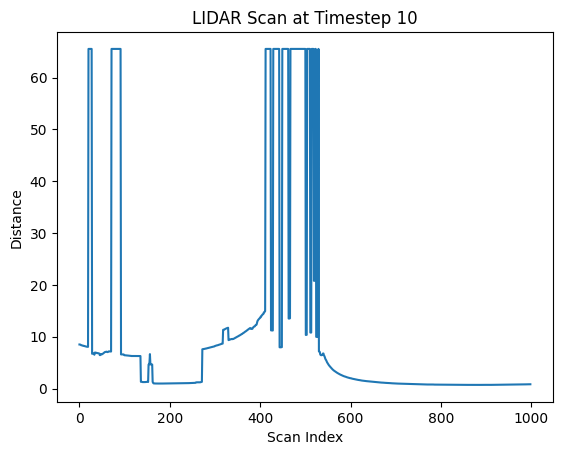

In [ ]:
import rosbag
import matplotlib.pyplot as plt

bag = rosbag.Bag('rosbags/pp_ETF1_2023-10-24-17-25-09.bag')

timestep = 0
ranges = None

for topic, msg, t in bag.read_messages(topics=['/scan_filtered']):
    timestep += 1
    if timestep == 20:
        ranges = msg.ranges
        break
    
# ranges = np.clip(ranges, a_min=None, a_max=15)
if ranges is not None:
    plt.figure()
    plt.plot(ranges)
    plt.title('LIDAR Scan at Timestep 10')
    plt.xlabel('Scan Index')
    plt.ylabel('Distance')
    plt.show()
else:
    print('No LIDAR scan found at timestep 10.')

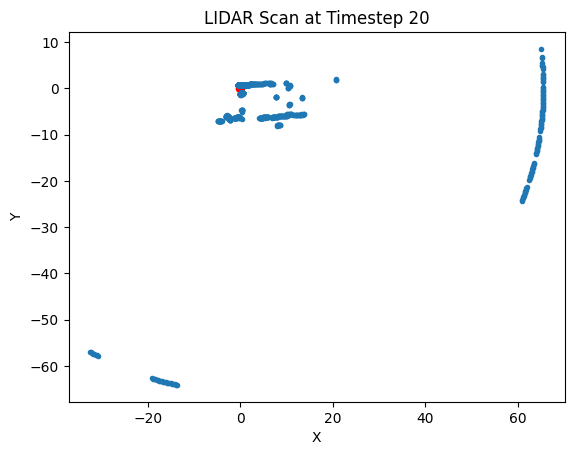

In [ ]:
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from sensor_msgs.msg import LaserScan

bag = rosbag.Bag('rosbags/pp_ETF1_2023-10-24-17-25-09.bag')

timestep = 0
ranges = None
angles = None

for topic, msg, t in bag.read_messages(topics=['/scan_filtered']):
    timestep += 1
    if timestep == 20:
        ranges = np.array(msg.ranges)
        angles = np.linspace(msg.angle_min, msg.angle_max, len(msg.ranges))
        break

if ranges is not None:
    # Clip the ranges at a maximum value of 15
    # ranges = np.clip(ranges, a_min=None, a_max=15)

    # Convert to Cartesian coordinates
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)

    plt.figure()
    plt.plot(x, y, '.')
    plt.scatter(0, 0, color='red')  # Add a red dot at (0,0)
    plt.title('LIDAR Scan at Timestep 20')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
else:
    print('No LIDAR scan found at timestep 20.')

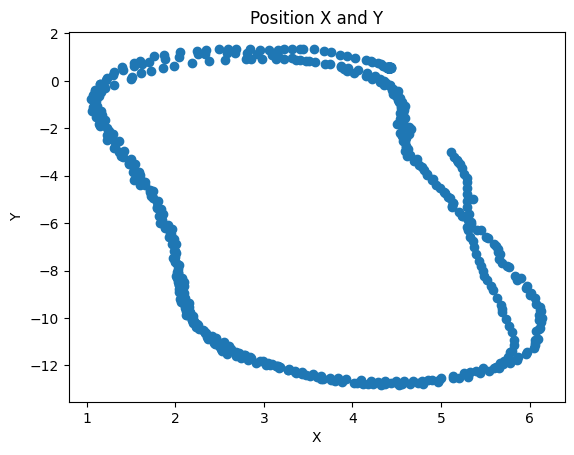

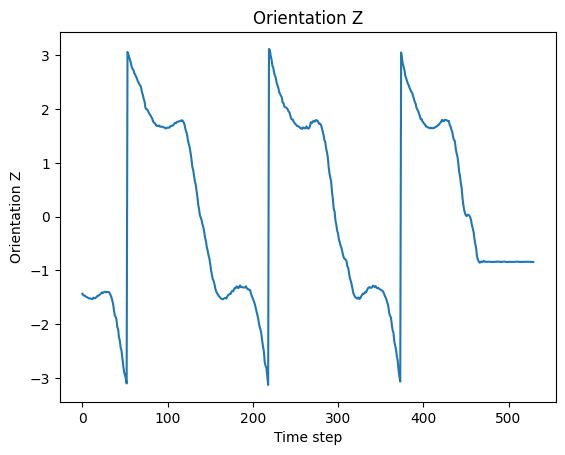

In [ ]:
# Particle filter position

import rosbag
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation


bag = rosbag.Bag('rosbags/pp_ETF1_2023-10-24-17-25-09.bag')

position_x = []
position_y = []
orientation_z = []

for topic, msg, t in bag.read_messages(topics=['/pf/viz/inferred_pose']):
    position_x.append(msg.pose.position.x)
    position_y.append(msg.pose.position.y)
    
    # Assuming msg.pose.orientation is an object with x, y, z, w as attributes
    quaternion = [msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w]
    rotation = Rotation.from_quat(quaternion)
    euler_angles = rotation.as_euler('xyz')
    orientation = euler_angles[2]  # z component   
    orientation_z.append(orientation)

position_x = np.array(position_x)
position_y = np.array(position_y)
orientation_z = np.array(orientation_z)

plt.figure()
plt.scatter(position_x, position_y)
plt.title('Position X and Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(orientation_z)
plt.title('Orientation Z')
plt.xlabel('Time step')
plt.ylabel('Orientation Z')
plt.show()